In [1]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import pandas
from io import StringIO
import sympy
import scipy
from sklearn.preprocessing import normalize
from pathlib import Path

In [2]:
# Funcion para correr .cpp

TP = "../src/main"
TEST_DIR = "../tests/"

def run_test(test_name: str, niter: int, eps: float): 
    !{TP} {TEST_DIR + test_name} {niter} {eps}

def run_test_pca(test_name: str, niter: int, eps: float, cant: int): 
    !{TP} {TEST_DIR + test_name} {niter} {eps} {cant}

def read_result_autovalores(test_result: str):
    return pandas.read_csv(TEST_DIR + test_result + '_autovalores.out', names=["autovalores"])

def read_result_autovectores(test_result: str):
    return pandas.read_csv(TEST_DIR + test_result + '_autovectores.out' , names=["autovectores"])

### 1. Tests metodo de la potencia

In [ ]:
# CASO SIMETRICO
A = np.array([
  [ 7,  2,  -3],
  [ 2,  2,  -2],
  [-3, -2,  -2]
])

# GUARDO TXT
np.savetxt("../tests/simetrico.txt", A, delimiter=' ')

# CORRO METODO
run_test("simetrico.txt", 100000, 1e-21)

# CARGO AUTOVALORES Y AUTOVECTORES
l = np.loadtxt("../tests/simetrico.txt_autovalores.out", dtype='f', delimiter=' ')
v = np.loadtxt("../tests/simetrico.txt_autovectores.out", dtype='f', delimiter=' ', usecols=range(3))

print(l)
print(v)


print(A @ v[:, 0])
print(l[0] * v[:,0])

for i in range(len(A)):
    print(i)
    print(np.allclose(A @ v[:, i], l[i] * v[:,i], 1e-6))


In [ ]:
# CASO (A) * (A traspuesta)
AT = A @ A.T
TA = A.T @ A

# GUARDO TXT
np.savetxt("../tests/AT.txt", AT, delimiter=' ')
np.savetxt("../tests/TA.txt", TA, delimiter=' ')

# CORRO METODO
run_test("AT.txt", 100000, 1e-21)
run_test("TA.txt", 100000, 1e-21)

# CARGO AUTOVALORES Y AUTOVECTORES
l_AT = np.loadtxt("../tests/AT.txt_autovalores.out", dtype='f', delimiter=' ')
v_AT = np.loadtxt("../tests/AT.txt_autovectores.out", dtype='f', delimiter=' ', usecols=range(3))

l_TA = np.loadtxt("../tests/TA.txt_autovalores.out", dtype='f', delimiter=' ')
v_TA = np.loadtxt("../tests/TA.txt_autovectores.out", dtype='f', delimiter=' ', usecols=range(3))

print(l_AT)
print(l_TA)
print("Bingo :)" if np.allclose(l_AT,l_TA) else "Bongo :(")
print("Bingo :)" if np.allclose(v_AT,v_TA) else "Bongo :(")

### Ej 2 Juli

### PCA

In [141]:
paths = []
imgs = []
for path in sorted(list(Path('caras').rglob('*/*.pgm'))):
    paths.append(path)
    imgs.append(plt.imread(path)[::2,::2]/255)
X = np.stack(imgs)

In [142]:
n = X.shape[0] # Cantidad de imagenes

X = X.reshape(n, -1) # X pasa a tener dimension n x (46 x 56)

X_centered = X - X.mean(0) # X.mean(0) devuelve un arreglo con la media de cada columna.

Mx = X_centered.T@X_centered/(n-1)  # Mx = Matriz de covarianza

# Calculo autovalores con numpy
# l, V = np.linalg.eigh(Mx)

# GUARDO TXT
#np.savetxt("../tests/pca.txt", Mx, fmt="%1.16e", delimiter=' ')

# CORRO METODO
#run_test("pca.txt", 10000, 1e-5)
#run_test_pca("pca.txt", 100000, 1e-16, 409)      # Con tolerancia 1e-16 converge rapido, con 1e-17 ya no

# CARGO AUTOVALORES Y AUTOVECTORES
l = np.loadtxt("../tests/pca.txt_autovalores.out", dtype='f', delimiter=' ')
v = np.loadtxt("../tests/pca.txt_autovectores.out", dtype='f', delimiter=' ', usecols=range(409))

#print(l)

### 2) b) PCA

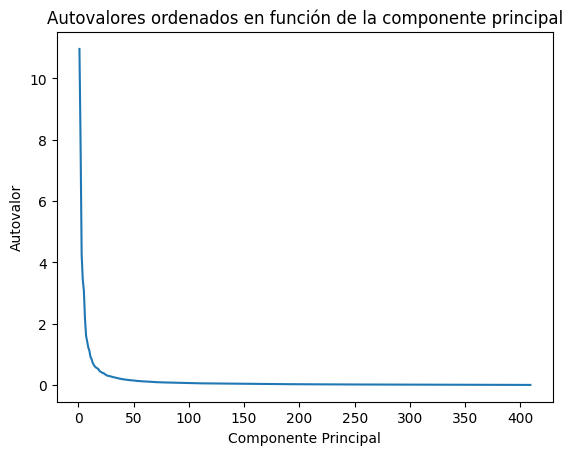

In [143]:
# Grafico los autovalores ordenados en función de las componentes principales
plt.plot(np.arange(1, len(l) + 1), l)
plt.xlabel('Componente Principal')
plt.ylabel('Autovalor')
plt.title('Autovalores ordenados en función de la componente principal')
plt.show()

### 2) c)

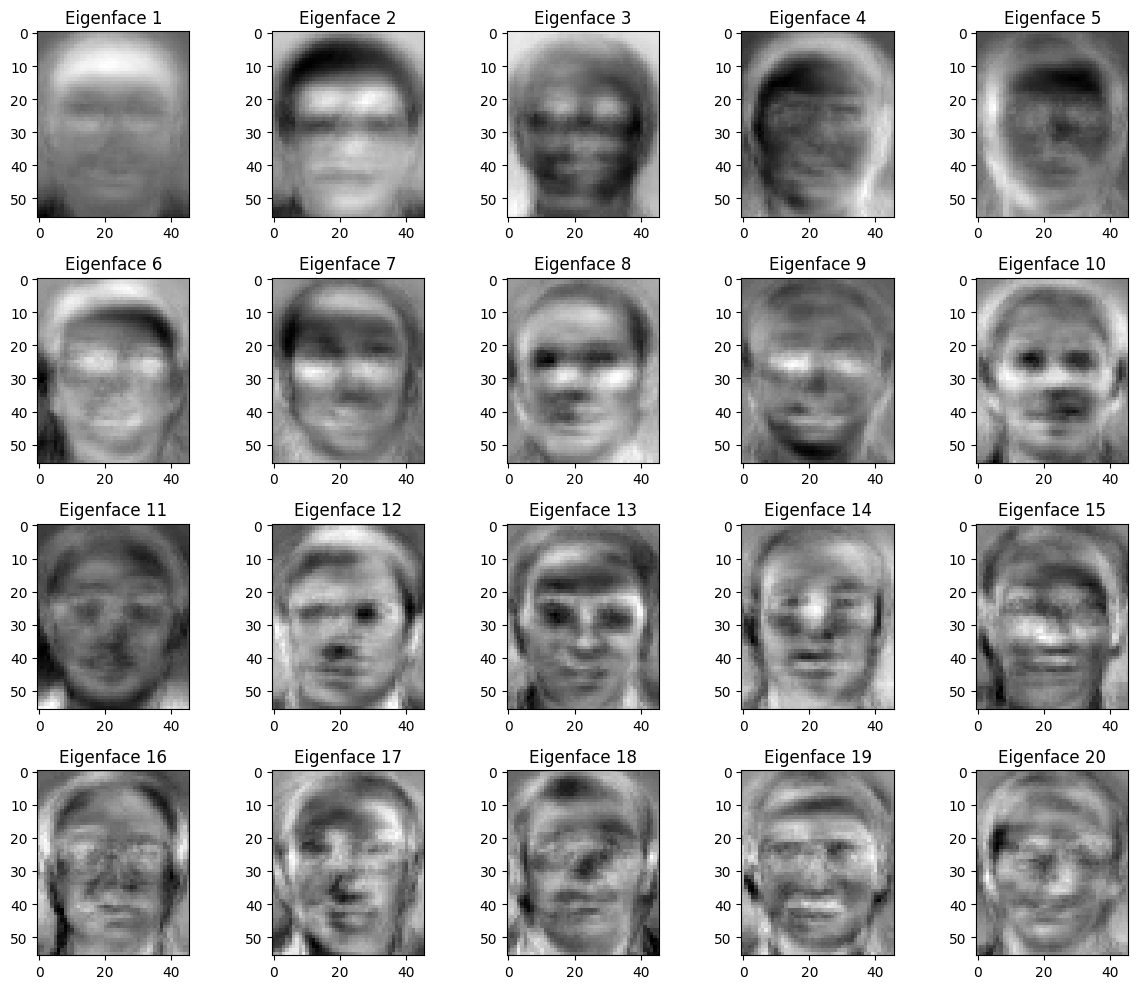

In [144]:
# Obtengo los primeros 20 autovectores correspondientes a los autovalores más grandes
num_eigenfaces = 20
eigenfaces = v[:, :num_eigenfaces]

# Normalizo las eigenfaces
eigenfaces /= np.linalg.norm(eigenfaces, axis=0)

fig, axes = plt.subplots(4, 5, figsize=(12, 10))
axes = axes.ravel()

for i in range(num_eigenfaces):
    eigenface = eigenfaces[:, i].reshape(56, 46)
    axes[i].imshow(eigenface, cmap='gray')
    axes[i].set_title(f'Eigenface {i+1}')

plt.tight_layout()
plt.show()

### 2) d) PCA

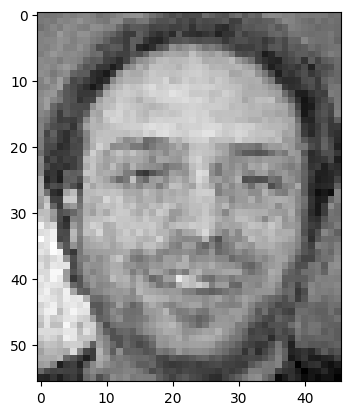

In [152]:
paths = []
imgs = []
for path in sorted(list(Path('caras').rglob('*/*.pgm'))):
    paths.append(path)
    imgs.append(plt.imread(path)[::2,::2]/255)
X = np.stack(imgs)


# # Imagen original
# plt.imshow(X[0], cmap='gray')


# Obtengo las primeras k componentes principales
k = 409  # Número deseado de componentes principales
componentes_principales = v[:, :k]

# Proyecto la imagen original en el espacio de las componentes principales
proyeccion = componentes_principales.T @ X[0].flatten()

# Reconstruyo la imagen a partir de las k componentes principales
imagen_reconstruida = componentes_principales @ proyeccion

# Reshape de la imagen reconstruida a la forma original
imagen_reconstruida = imagen_reconstruida.reshape(X[0].shape)

plt.imshow(imagen_reconstruida, cmap='gray')
plt.show()

### =======================================================================================

### 2DPCA

In [4]:
paths = []
imgs = []
for path in sorted(list(Path('caras').rglob('*/*.pgm'))):
    paths.append(path)
    imgs.append(plt.imread(path)[::,::]/255)
X = np.stack(imgs)

La variante 2DPCA 2 considera una imagen en su espacio original como una matriz A ∈ Ra×b
y le asocia un feature vector Y ∈ Ra, mediante la transformacion lineal Y = AX siendo
X ∈ Rb el vector que maximiza la dispersion de los features vectors obtenidos para todo el
conjunto de imagenes. Se puede ver que la eleccion  ́optima para el vector de proyeccion X
se corresponde con el autovector de maximo autovalor de la denominada image covariance
matrix

In [27]:
print(f"Tengo {X.shape[0]} imagenes de tamano {X.shape[1]}x{X.shape[2]}")
# A es la imagen
imgs = X

n = imgs.shape[0] # Cantidad de imagenes

A_prom = np.zeros(shape=(imgs.shape[1], imgs.shape[2]))

for i in range (n):
    A_prom += imgs[i]

A_prom /= n

# G = image covariance matrix (quiero calcularle autovalores y autovectores)
suma = 0
for j in range (n): 
    suma += ((np.transpose(imgs[j] - A_prom)) @ (imgs[j] - A_prom))
G = (1/n) * suma

# GUARDO TXT
#np.savetxt("../tests/2dpca_g.txt", G, delimiter=' ')

# # CORRO METODO
#run_test("2dpca_g.txt", 100000, 1e-21)

Tengo 410 imagenes de tamano 112x92


(410, 112, 92)

In [61]:
# Cargo autovalores y autovectores
l_G = np.loadtxt("../tests/2dpca_g.txt_autovalores.out", dtype='f', delimiter=' ')
v_G = np.loadtxt("../tests/2dpca_g.txt_autovectores.out", dtype='f', delimiter=' ', usecols=range(G.shape[0]))
v_G_transpose = v_G.T

# normalizo cada autovector
num_autovectores = v_G.shape[1]
for i in range(num_autovectores):
    norm = np.linalg.norm(v_G[:, i])
    v_G[:, i] /= norm

### 2) b) 2DPCA


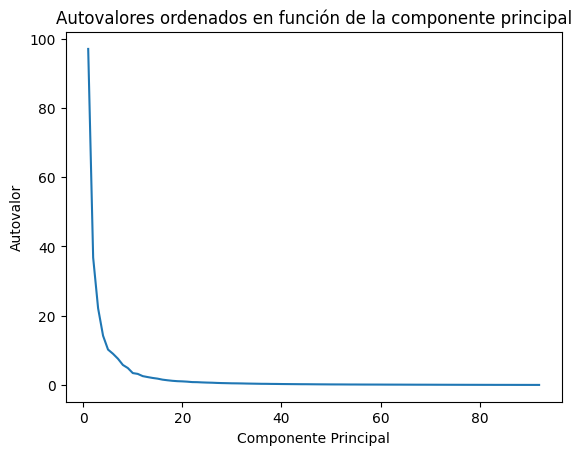

In [107]:
# Grafico los autovalores ordenados en función de las componentes principales
plt.plot(np.arange(1, len(l_G) + 1), l_G)
plt.xlabel('Componente Principal')
plt.ylabel('Autovalor')
plt.title('Autovalores ordenados en función de la componente principal')
plt.show()

### 2) c) 2DPCA

In [127]:
# EIGENFACES 2DPCA?

### 2) d) 2DPCA

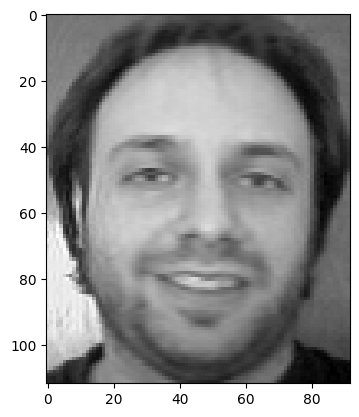

In [132]:
# feat_vecs de cada imagen
feature_vectors = imgs[0] @ v_G
# Son equivalentes estas dos
# A = imgs[x]
A = feature_vectors @ (v_G.T)

# Luego, el producto de arriba se puede descomponer como el producto externo
# Aca entran las k componentes.
k = 50

A_2 = np.zeros_like(A)
for j in range(k):
    A_2 += np.outer(feature_vectors[:,j], (v_G[:,j]).T)


plt.imshow(A_2, cmap='gray')
plt.show()

### Ej 3